# DonorsChoose : Application Screening

## Description
<p> Source : https://www.kaggle.com/c/donorschoose-application-screening </p>
<p> Download train.zip and resources.zip from Kaggle.</p> 

### Problem statement :
<p> Predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved or not </p>

## Performance Metric

Source: https://www.kaggle.com/c/donorschoose-application-screening/overview/evaluation

Metric(s):

    Area Under Curve (AOC)
    Confusion Matrix

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, confusion_matrix

from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
import string
import re
import os
import pickle
from collections import Counter

## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 1.2 preprocessing of `project_subject_categories`

In [0]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

catogories = list(project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_catogories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [15]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:09<00:00, 1573.17it/s]


In [16]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [17]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
preprocessed_titles[5438]

100%|██████████| 109248/109248 [00:03<00:00, 32938.77it/s]


'mac imize steam'

## 1.5 Preparing data for models

In [18]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

__ Computing Sentiment Scores__

In [20]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>2. Support Vector Machines </h1>

### Preparing data for set 5

In [21]:
#sentiment socre
from nltk.sentiment.vader import SentimentIntensityAnalyzer
t = []

sid = SentimentIntensityAnalyzer()
for essay in preprocessed_essays:       #takes around 5 mins to run.
    ss = sid.polarity_scores(essay)
    t.append([ss['neg'],ss['neu'],ss['pos'],ss['compound']])

temp = pd.DataFrame(t, columns = {'neg', 'neu', 'pos', 'compound'})
temp['id'] = project_data['id']
del t

project_data = pd.merge(project_data, temp, on='id', how='left')
print(project_data.shape)

(109248, 24)


In [22]:
#number of words in the title : numerical data
now_title = []
for title in preprocessed_titles:
    now_title.append(len(title.split()))

temp = pd.DataFrame(now_title, columns = {'now_title'})
temp['id'] = project_data['id']

project_data = pd.merge(project_data, temp, on='id', how='left')
print(project_data.shape)

(109248, 25)


In [23]:
#number of words in the combine essays : numerical data
now_essay = []
for essay in preprocessed_essays:
    now_essay.append(len(essay.split()))

temp = pd.DataFrame(now_essay, columns = {'now_essay'})
temp['id'] = project_data['id']

project_data = pd.merge(project_data, temp, on='id', how='left')   
print(project_data.shape)

(109248, 26)


<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [24]:
print(project_data.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'pos', 'neu', 'compound', 'neg', 'now_title', 'now_essay'],
      dtype='object')


In [25]:
#importing required libraries
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

#creating input and output parts
X = project_data[:].drop('project_is_approved', axis = 1)
Y = project_data[:]['project_is_approved']

#replacing essay and title column with preprocessed texts as it is needed in bow, tfidf,.. encoding
X['essay'] = preprocessed_essays[:]
X['project_title'] = preprocessed_titles[:]

#splitting the data into train/test
X_tr, X_test, Y_tr, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)

print("Shape of train and test data is : ",X_tr.shape, X_test.shape)

Shape of train and test data is :  (87398, 25) (21850, 25)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

### 2.2.1 Encoding Categorical features

In [26]:
#Encoding project_categories for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
categories_tr = vectorizer.fit_transform(X_tr['clean_categories'].values)
categories_test = vectorizer.transform(X_test['clean_categories'].values)

print("Shape of matrix after one hot encoding ",categories_tr.shape)
print("Shape of matrix after one hot encoding ",categories_test.shape)

Shape of matrix after one hot encoding  (87398, 9)
Shape of matrix after one hot encoding  (21850, 9)


In [27]:
#Encoding project_subcategories for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
subcategories_tr = vectorizer.fit_transform(X_tr['clean_subcategories'].values)
subcategories_test = vectorizer.transform(X_test['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ",subcategories_tr.shape)
print("Shape of matrix after one hot encoding ",subcategories_test.shape)

Shape of matrix after one hot encoding  (87398, 30)
Shape of matrix after one hot encoding  (21850, 30)


In [28]:
#Encoding school_state for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
school_state_tr = vectorizer.fit_transform(X_tr['school_state'].values)
school_state_test = vectorizer.transform(X_test['school_state'].values)

print("Shape of matrix after one hot encoding ",school_state_tr.shape)
print("Shape of matrix after one hot encoding ",school_state_test.shape)

Shape of matrix after one hot encoding  (87398, 51)
Shape of matrix after one hot encoding  (21850, 51)


In [29]:
#Encoding teacher_prefix for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
teacher_prefix_tr = vectorizer.fit_transform(map(str,X_tr['teacher_prefix'].values))
teacher_prefix_test = vectorizer.transform(map(str,X_test['school_state'].values))

print("Shape of matrix after one hot encoding ",teacher_prefix_tr.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_test.shape)

Shape of matrix after one hot encoding  (87398, 6)
Shape of matrix after one hot encoding  (21850, 6)


In [30]:
#Encoding project_grade_category for all sets
vectorizer = CountVectorizer(lowercase=False, binary=True)
project_grade_category_tr = vectorizer.fit_transform(X_tr['project_grade_category'].values)
project_grade_category_test = vectorizer.transform(X_test['project_grade_category'].values)

print("Shape of matrix after one hot encoding ",project_grade_category_tr.shape)
print("Shape of matrix after one hot encoding ",project_grade_category_test.shape)

Shape of matrix after one hot encoding  (87398, 3)
Shape of matrix after one hot encoding  (21850, 3)


### 2.2.2 Encoding Numerical Features

In [0]:
#Standarizing for all sets, try printing their shape to test if code is correct or not
scalar = StandardScaler()
price_tr = scalar.fit_transform(X_tr['price'].values.reshape(-1, 1))
price_test = scalar.transform(X_test['price'].values.reshape(-1, 1))

In [0]:
#Standarizing for all sets, try printing their shape to test if code is correct or not
scalar = StandardScaler()
tnopp_tr = scalar.fit_transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
tnopp_test = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [0]:
scalar = StandardScaler()
quantity_tr = scalar.fit_transform(X_tr['quantity'].values.reshape(-1, 1))
quantity_test = scalar.transform(X_test['quantity'].values.reshape(-1, 1))

In [0]:
scalar = StandardScaler()
now_title_tr = scalar.fit_transform(X_tr['now_title'].values.reshape(-1,1))
now_title_test = scalar.transform(X_test['now_title'].values.reshape(-1,1))

In [0]:
scalar = StandardScaler()
now_essay_tr = scalar.fit_transform(X_tr['now_essay'].values.reshape(-1,1))
now_essay_test = scalar.transform(X_test['now_essay'].values.reshape(-1,1))

In [0]:
pos_tr = X_tr['pos'].reshape(-1,1)
pos_test = X_test['pos'].reshape(-1,1)

In [0]:
compound_tr = X_tr['compound'].reshape(-1,1)
compound_test = X_test['compound'].reshape(-1,1)

In [0]:
neu_tr = X_tr['neu'].reshape(-1,1)
neu_test = X_test['neu'].reshape(-1,1)

In [0]:
neg_tr = X_tr['neg'].reshape(-1,1)
neg_test = X_test['neg'].reshape(-1,1)

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### 2.3.1 Encoding using bow

In [49]:
#Encoding essay for each data set using bow
vectorizer = CountVectorizer(min_df=10)
e_bow_tr = vectorizer.fit_transform(X_tr['essay'])
e_bow_test = vectorizer.transform(X_test['essay'])

print("Shape of matrix after bow encoding ",e_bow_tr.shape)
print("Shape of matrix after bow encoding ",e_bow_test.shape)

Shape of matrix after bow encoding  (87398, 15256)
Shape of matrix after bow encoding  (21850, 15256)


In [50]:
#Encoding title for each data set using bow
vectorizer = CountVectorizer(min_df=10)
t_bow_tr = vectorizer.fit_transform(X_tr['project_title'])
t_bow_test = vectorizer.transform(X_test['project_title'])

print("Shape of matrix after bow encoding ",t_bow_tr.shape)
print("Shape of matrix after bow encoding ",t_bow_test.shape)

Shape of matrix after bow encoding  (87398, 2926)
Shape of matrix after bow encoding  (21850, 2926)


### 2.3.2 Encoding using tfidf

In [40]:
#Encoding essay for each data set using tfidf
vectorizer = TfidfVectorizer(min_df=10)
e_tfidf_tr = vectorizer.fit_transform(X_tr['essay'])
e_tfidf_test = vectorizer.transform(X_test['essay'])

print("Shape of matrix after tfidf encoding ",e_tfidf_tr.shape)
print("Shape of matrix after tfidf encoding ",e_tfidf_test.shape)

Shape of matrix after tfidf encoding  (87398, 15256)
Shape of matrix after tfidf encoding  (21850, 15256)


In [41]:
#Encoding title for each data set using tfidf
vectorizer = TfidfVectorizer(min_df=10)
t_tfidf_tr = vectorizer.fit_transform(X_tr['project_title'])
t_tfidf_test = vectorizer.transform(X_test['project_title'])

print("Shape of matrix after tfidf encoding ",t_tfidf_tr.shape)
print("Shape of matrix after tfidf encoding ",t_tfidf_test.shape)

Shape of matrix after tfidf encoding  (87398, 2926)
Shape of matrix after tfidf encoding  (21850, 2926)


### 2.3.3 Encoding using avg_w2v

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# average Word2Vec for essay
# compute average word2vec for training set.
e_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    e_w2v_tr.append(vector)


# compute average word2vec for test set.
e_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    e_w2v_test.append(vector)

print(len(e_w2v_tr))
print(len(e_w2v_test))

100%|██████████| 21850/21850 [00:07<00:00, 3038.13it/s]

87398
21850


In [0]:
# average Word2Vec for title
# compute average word2vec for training set.
t_w2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    t_w2v_tr.append(vector)


# compute average word2vec for test set.
t_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    t_w2v_test.append(vector)

print(len(t_w2v_tr))
print(len(t_w2v_test))

100%|██████████| 21850/21850 [00:00<00:00, 55764.70it/s]

87398
21850


### 2.3.4 Encoding using weigthed_w2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# weighted Word2Vec for essay
# compute weighted word2vec for training set.
e_ww2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    e_ww2v_tr.append(vector)

    
# average Word2Vec
# compute average word2vec for test set.
e_ww2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    e_ww2v_test.append(vector)

print(len(e_ww2v_tr))
print(len(e_ww2v_test))

100%|██████████| 21850/21850 [00:49<00:00, 441.41it/s]

87398
21850


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# weighted Word2Vec for title
# compute weighted word2vec for training set.
t_ww2v_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    t_ww2v_tr.append(vector)

    
# average Word2Vec
# compute average word2vec for test set.
t_ww2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    t_ww2v_test.append(vector)

print(len(t_ww2v_tr))
print(len(t_ww2v_test))

100%|██████████| 21850/21850 [00:01<00:00, 20165.65it/s]

87398
21850


### 2.3.5 Writing some functions 

In [0]:
#function for cross validation using gridsearchcv
def cross_val(alpha, penalty):
    parameters = {'alpha' : alpha, 'penalty' : penalty}
    classifier = SGDClassifier(loss = 'hinge')
    model = GridSearchCV(classifier, param_grid = parameters, scoring = 'roc_auc')
    model.fit(Xtr, Y_tr)
    return model

In [0]:
#printing auc values
def print_auc_values(model):
    results = pd.DataFrame(model.cv_results_)          #storing results of gridseachcv in a dataframe to access its elements
    params = results['params']                         #storing combination of parameters used by model in params
    auc_tr_array = results['mean_train_score']         #storing scores on train data of model
    auc_cv_array = results['mean_test_score']          #storing scores on cv data of model
    for i in range(len(params)):
        print("For penalty = ",params[i]['penalty'],"and alpha = ",params[i]['alpha'],"AUC of Train data is",auc_tr_array[i],"and AUC of CV data is", auc_cv_array[i])

In [0]:
#plotting auc values
def plotting_auc_values(model, alpha, penalty):
    plt.figure(figsize=(20,4))

    plt.subplot(1, 2, 1)
    scores_tr = model.cv_results_['mean_train_score'].reshape(len(alpha),len(penalty))
    sns.heatmap(scores_tr, annot=True, xticklabels=penalty, yticklabels=alpha)
    plt.xlabel('Penalty')
    plt.ylabel('Alpha')
    plt.title('Heatmap of train data')

    plt.subplot(1, 2, 2)
    scores_test = model.cv_results_['mean_test_score'].reshape(len(alpha),len(penalty))
    sns.heatmap(scores_test, annot=True, xticklabels=penalty, yticklabels=alpha)
    plt.xlabel('Penalty')
    plt.ylabel('Alpha')
    plt.title('Heatmap of test data')
    plt.show()

In [0]:
#plotting roc curve : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test):
    fpr, tpr, threshold = roc_curve(Y_tr,  pred_tr)
    plt.plot(fpr, tpr, color = 'Red', label="Train data, auc="+str(auc_tr))
    fpr, tpr, threshold = roc_curve(Y_test,  pred_test)
    plt.plot(fpr ,tpr ,color = 'Blue', label="Test data , auc="+str(auc_test))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of Train and Test data for best parameter')
    plt.show()
    return fpr, tpr, threshold

In [0]:
# Function for predict, with defined thresould that will give the least fpr
def predict(proba, fpr, tpr, threshould):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
#plotting confusion matrix : http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
def plot_cm(pred):
    cm = confusion_matrix(Y_test, pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix of Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

<h2>2.4 Appling Support Vector Machines on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Support Vector Machines on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Applying Linear SVM on BOW,<font color='red'> SET 1</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
For penalty =  l1 and alpha =  0.0001 AUC of Train data is 0.7400891349521169 and AUC of CV data is 0.641613304758007
For penalty =  l2 and alpha =  0.0001 AUC of Train data is 0.7746041733079988 and AUC of CV data is 0.6694831786404996
For penalty =  l1 and alpha =  0.001 AUC of Train data is 0.6361295936423755 and AUC of CV data is 0.6224566993963017
For penalty =  l2 and alpha =  0.001 AUC of Train data is 0.7879100662527868 and AUC of CV data is 0.6840391313151851
For penalty =  l1 and alpha =  0.01 AUC of Train data is 0.559607059186612 and AUC of CV data is 0.5577169363470058
For penalty =  l2 and alpha =  0.01 AUC of Train data is 0.7879684273345916 and AUC of CV data is 0.6907292097807199
For penalty =  l1 and alpha =  0.1 AUC of Train data is 0.5460360940834569 and AUC of CV data is 0.5458295407007021
For penalty =  l2 and alpha =  0.1 AUC of Train data is 0.6876793802576207 and AUC of CV data is 0.65828351435059

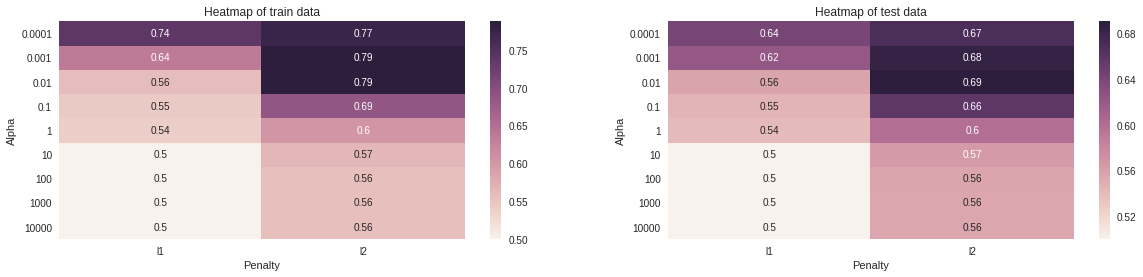

Values of best parameters are {'alpha': 0.01, 'penalty': 'l2'} and auc value is 0.6907292097807199
For best parameters AUC of Train data is 0.7637545510554196 and AUC of Test data is 0.6938131721678846


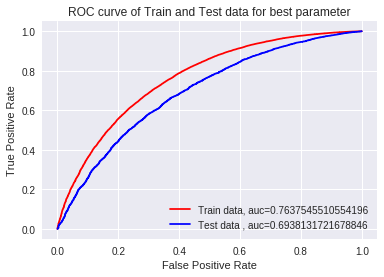

The maximum value of tpr*(1-fpr) 0.41597178216394404 for threshold 0.955


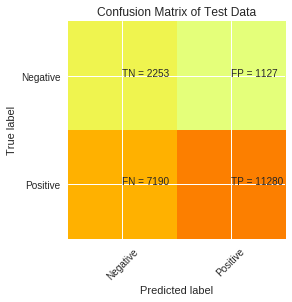

In [51]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_bow_tr, t_bow_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_bow_test, t_bow_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ['l1', 'l2']
model = cross_val(alpha, penalty)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, alpha, penalty)

#Using model with best parameters
param_bow = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr)
pred_test = model.decision_function(Xtest)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr, tpr, threshold = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred = predict(pred_test, fpr, tpr, threshold)

#Plotting confusion matrix
plot_cm(pred)

#stroing auc_test value for Conclusion
auc_bow = auc_test

### 2.4.2 Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Shape of train and test data is :  (87398, 18283) (21850, 18283)
For penalty =  l1 and alpha =  0.0001 AUC of Train data is 0.6852722247526527 and AUC of CV data is 0.6711741115623652
For penalty =  l2 and alpha =  0.0001 AUC of Train data is 0.7802212429376119 and AUC of CV data is 0.6833867594508363
For penalty =  l1 and alpha =  0.001 AUC of Train data is 0.5649219191072462 and AUC of CV data is 0.5664515787171449
For penalty =  l2 and alpha =  0.001 AUC of Train data is 0.7768039938799901 and AUC of CV data is 0.6730380238248521
For penalty =  l1 and alpha =  0.01 AUC of Train data is 0.5238731974309486 and AUC of CV data is 0.5248761180015662
For penalty =  l2 and alpha =  0.01 AUC of Train data is 0.7743814555191334 and AUC of CV data is 0.6793375268272476
For penalty =  l1 and alpha =  0.1 AUC of Train data is 0.5 and AUC of CV data is 0.5
For penalty =  l2 and alpha =  0.1 AUC of Train data is 0.5581284962431798 and AUC of CV data is 0.5505775217548953
For penalty =  l1 and alp

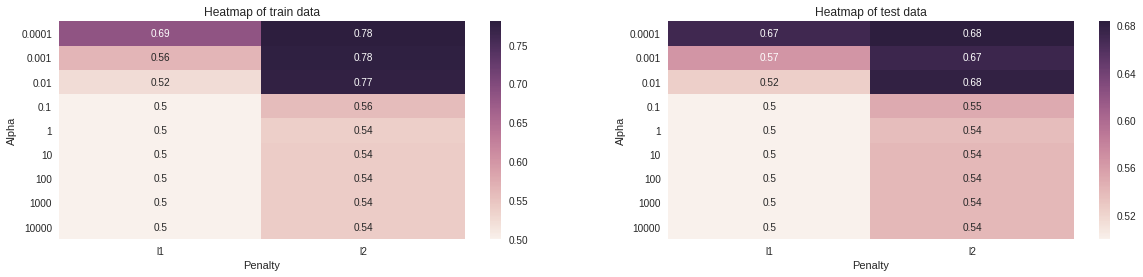

Values of best parameters are {'alpha': 0.0001, 'penalty': 'l2'} and auc value is 0.6833867594508363
For best parameters AUC of Train data is 0.7511950858594363 and AUC of Test data is 0.6687210509285808


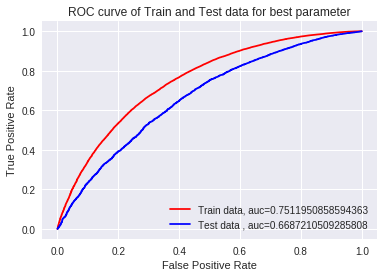

The maximum value of tpr*(1-fpr) 0.3906391781971724 for threshold 1.025


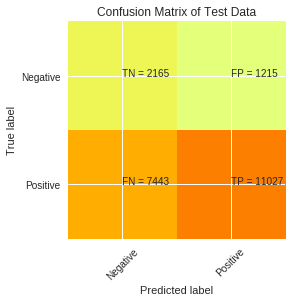

In [0]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_tfidf_tr, t_tfidf_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_tfidf_test, t_tfidf_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ['l1', 'l2']
model = cross_val(alpha, penalty)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, alpha, penalty)

#Using model with best parameters
param_tfidf = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr)
pred_test = model.decision_function(Xtest)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr, tpr, threshold = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred = predict(pred_test, fpr, tpr, threshold)

#Plotting confusion matrix
plot_cm(pred)

#stroing auc_test value for Conclusion
auc_tfidf = auc_test

### 2.4.3 Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Shape of train and test data is :  (87398, 701) (21850, 701)
For penalty =  l1 and alpha =  0.0001 AUC of Train data is 0.6963132841008033 and AUC of CV data is 0.6871918891353993
For penalty =  l2 and alpha =  0.0001 AUC of Train data is 0.6760434499403564 and AUC of CV data is 0.657225993457095
For penalty =  l1 and alpha =  0.001 AUC of Train data is 0.6073918076255218 and AUC of CV data is 0.6114497344027157
For penalty =  l2 and alpha =  0.001 AUC of Train data is 0.6865430338004991 and AUC of CV data is 0.6704190881344675
For penalty =  l1 and alpha =  0.01 AUC of Train data is 0.4589739395417991 and AUC of CV data is 0.4592866420942572
For penalty =  l2 and alpha =  0.01 AUC of Train data is 0.6213439354087408 and AUC of CV data is 0.6079054541086024
For penalty =  l1 and alpha =  0.1 AUC of Train data is 0.4413253635140757 and AUC of CV data is 0.4413256474764958
For penalty =  l2 and alpha =  0.1 AUC of Train data is 0.5241824250491899 and AUC of CV data is 0.5182802598399722


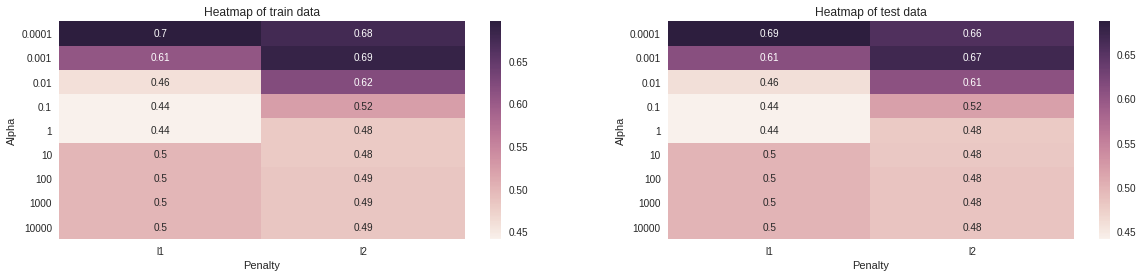

Values of best parameters are {'alpha': 0.0001, 'penalty': 'l1'} and auc value is 0.6871918891353993
For best parameters AUC of Train data is 0.6935610740561613 and AUC of Test data is 0.6877551314621824


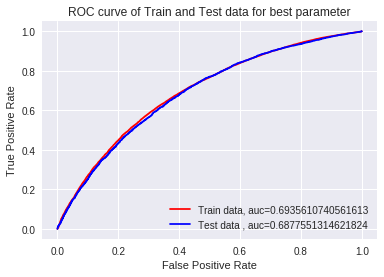

The maximum value of tpr*(1-fpr) 0.40974316258894167 for threshold 1.597


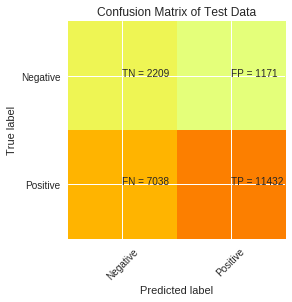

In [0]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_w2v_tr, t_w2v_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_w2v_test, t_w2v_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ['l1', 'l2']
model = cross_val(alpha, penalty)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, alpha, penalty)

#Using model with best parameters
param_w2v = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr)
pred_test = model.decision_function(Xtest)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr, tpr, threshold = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred = predict(pred_test, fpr, tpr, threshold)

#Plotting confusion matrix
plot_cm(pred)

#stroing auc_test value for Conclusion
auc_w2v = auc_test

### 2.4.4 Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Shape of train and test data is :  (87398, 701) (21850, 701)
For penalty =  l1 and alpha =  0.0001 AUC of Train data is 0.6859956075082095 and AUC of CV data is 0.6721455678326318
For penalty =  l2 and alpha =  0.0001 AUC of Train data is 0.6617220716912552 and AUC of CV data is 0.6412070339538659
For penalty =  l1 and alpha =  0.001 AUC of Train data is 0.6471246942623173 and AUC of CV data is 0.6408197636537128
For penalty =  l2 and alpha =  0.001 AUC of Train data is 0.6704763023850878 and AUC of CV data is 0.650875804573591
For penalty =  l1 and alpha =  0.01 AUC of Train data is 0.5195833487899573 and AUC of CV data is 0.5178223315464126
For penalty =  l2 and alpha =  0.01 AUC of Train data is 0.6396122607909918 and AUC of CV data is 0.6251121824507522
For penalty =  l1 and alpha =  0.1 AUC of Train data is 0.4422478589487519 and AUC of CV data is 0.44158663061492887
For penalty =  l2 and alpha =  0.1 AUC of Train data is 0.5533705927779442 and AUC of CV data is 0.5479628902360169

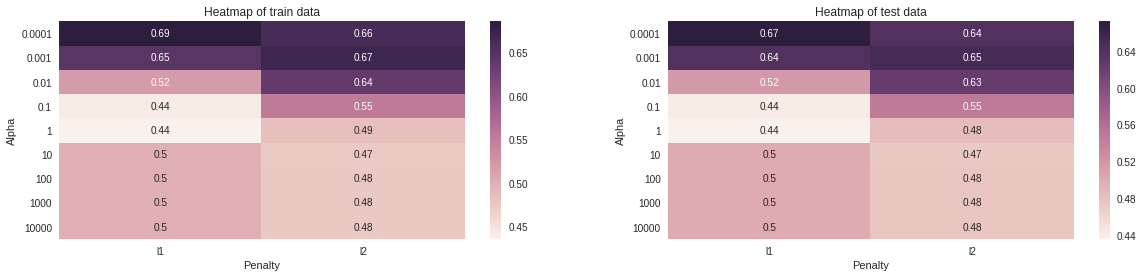

Values of best parameters are {'alpha': 0.0001, 'penalty': 'l1'} and auc value is 0.6721455678326318
For best parameters AUC of Train data is 0.6778593699650455 and AUC of Test data is 0.6602655353475811


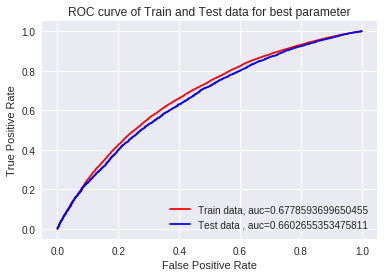

The maximum value of tpr*(1-fpr) 0.37996242106983014 for threshold 1.0


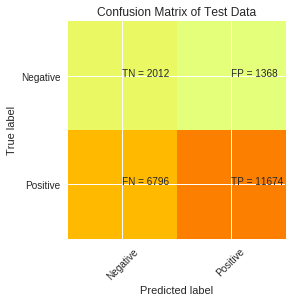

In [0]:
#Merging all sparse matrix
Xtr = hstack((school_state_tr,categories_tr, subcategories_tr, teacher_prefix_tr, project_grade_category_tr, e_ww2v_tr, t_ww2v_tr, price_tr, tnopp_tr)).tocsr()   
Xtest = hstack((school_state_test,categories_test, subcategories_test, teacher_prefix_test, project_grade_category_test, e_ww2v_test, t_ww2v_test, price_test, tnopp_test)).tocsr()
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ['l1', 'l2']
model = cross_val(alpha, penalty)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, alpha, penalty)

#Using model with best parameters
param_ww2v = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr)
pred_test = model.decision_function(Xtest)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr, tpr, threshold = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred = predict(pred_test, fpr, tpr, threshold)

#Plotting confusion matrix
plot_cm(pred)

#stroing auc_test value for Conclusion
auc_ww2v = auc_test

<h2>2.5 Support Vector Machines with added Features `Set 5` </h2>

In [52]:
#tested with diff. dims, taking 3500 because colab gives memeory error for more than 3500 dims
svd = TruncatedSVD(n_components = 3500)

svd_data = svd.fit(e_tfidf_tr)
explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio", explained_variance * 100)

Sum of explained variance ratio 83.22863021679194


In [54]:
e_tfidf_svd_tr = svd_data.transform(e_tfidf_tr)
e_tfidf_svd_test = svd_data.transform(e_tfidf_test)
print("Shape of matrix after applying svd ",e_tfidf_svd_tr.shape)
print("Shape of matrix after applying svd ",e_tfidf_svd_test.shape)

Shape of matrix after applying svd  (87398, 3500)
Shape of matrix after applying svd  (21850, 3500)


Shape of train and test data is :  (87398, 3608) (21850, 3608)
For penalty =  l1 and alpha =  0.0001 AUC of Train data is 0.6766641151707679 and AUC of CV data is 0.6672988099006656
For penalty =  l2 and alpha =  0.0001 AUC of Train data is 0.719932576157101 and AUC of CV data is 0.6792831883504579
For penalty =  l1 and alpha =  0.001 AUC of Train data is 0.5994464790133031 and AUC of CV data is 0.598023749724866
For penalty =  l2 and alpha =  0.001 AUC of Train data is 0.739939895493872 and AUC of CV data is 0.6976603068868921
For penalty =  l1 and alpha =  0.01 AUC of Train data is 0.5551220650511947 and AUC of CV data is 0.5488268780782302
For penalty =  l2 and alpha =  0.01 AUC of Train data is 0.7322393648079979 and AUC of CV data is 0.6879844653032792
For penalty =  l1 and alpha =  0.1 AUC of Train data is 0.5 and AUC of CV data is 0.5
For penalty =  l2 and alpha =  0.1 AUC of Train data is 0.7304071644335247 and AUC of CV data is 0.6872647248607986
For penalty =  l1 and alpha = 

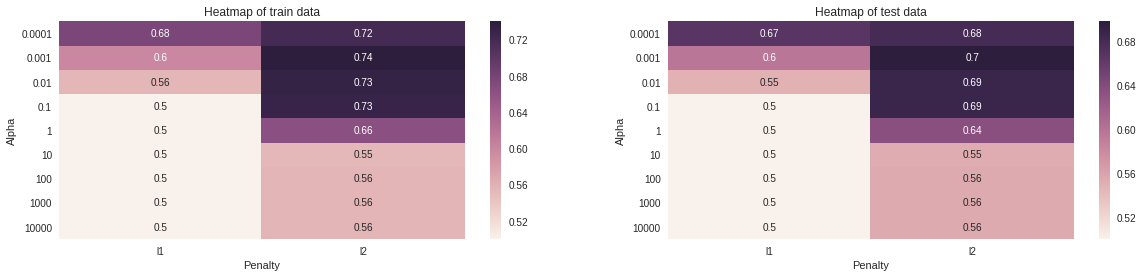

Values of best parameters are {'alpha': 0.001, 'penalty': 'l2'} and auc value is 0.6976603068868921
For best parameters AUC of Train data is 0.7309534757339556 and AUC of Test data is 0.7085771425276235


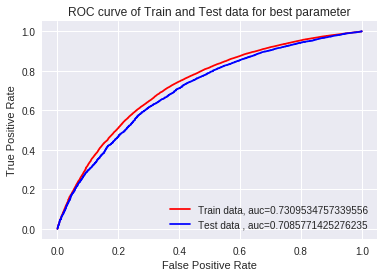

The maximum value of tpr*(1-fpr) 0.4313296149521213 for threshold 1.101


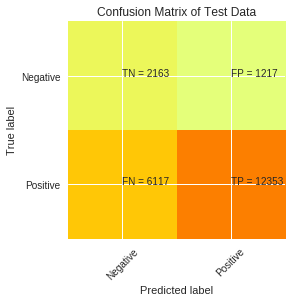

In [60]:
#Converting sparse matrix to array and then combining with numpy.hstack, Not combining with scipy.hstack as most values are normal arrays and not sparse arrays. 
Xtr = np.hstack((school_state_tr.toarray(), categories_tr.toarray(), subcategories_tr.toarray(), teacher_prefix_tr.toarray(), project_grade_category_tr.toarray(), e_tfidf_svd_tr, quantity_tr, price_tr, tnopp_tr, now_title_tr, now_essay_tr, pos_tr, compound_tr, neu_tr, neg_tr))   
Xtest = np.hstack((school_state_test.toarray(), categories_test.toarray(), subcategories_test.toarray(), teacher_prefix_test.toarray(), project_grade_category_test.toarray(), e_tfidf_svd_test, quantity_test, price_test, tnopp_test, now_title_test, now_essay_test, pos_test, compound_test, neu_test, neg_test))
print("Shape of train and test data is : ",Xtr.shape, Xtest.shape)

#Using gridsearchcv find best value for alpha and penalty
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ['l1', 'l2']
model = cross_val(alpha, penalty)

#printing auc values
print_auc_values(model)

#plotting auc values
plotting_auc_values(model, alpha, penalty)

#Using model with best parameters
param_set5 = model.best_params_
print("Values of best parameters are",model.best_params_,"and auc value is", model.best_score_)
pred_tr = model.decision_function(Xtr)
pred_test = model.decision_function(Xtest)
auc_tr = roc_auc_score(Y_tr, pred_tr)
auc_test = roc_auc_score(Y_test, pred_test)
print("For best parameters AUC of Train data is",auc_tr,"and AUC of Test data is", auc_test)

#Plotting ROC curve of Train and Test data for best parameter
fpr, tpr, threshold = plot_roc_curve(pred_tr, pred_test, auc_tr, auc_test)

#getting predictions using defined threshold
pred = predict(pred_test, fpr, tpr, threshold)

#Plotting confusion matrix
plot_cm(pred)

#stroing auc_test value for Conclusion
auc_set5 = auc_test

<h1>3. Conclusion</h1>

In [0]:
# Please compare all your models using Prettytable library
t = PrettyTable()
t.field_names = ["Vectorizer", "Model", "Hyperparameter","AUC"]
t.add_row(["BOW", "Linear SVM", param_bow, auc_bow])
t.add_row(["TFIDF", "Linear SVM", param_tfidf, auc_tfidf])
t.add_row(["W2V", "Linear SVM", param_w2v, auc_w2v])
t.add_row(["TFIDFW2V", "Linear SVM", param_ww2v, auc_ww2v])
print(t)

+------------+------------+------------------------------------+--------------------+
| Vectorizer |   Model    |           Hyperparameter           |        AUC         |
+------------+------------+------------------------------------+--------------------+
|    BOW     | Linear SVM |  {'alpha': 0.01, 'penalty': 'l2'}  | 0.7006702216612257 |
|   TFIDF    | Linear SVM | {'alpha': 0.0001, 'penalty': 'l2'} | 0.6687210509285808 |
|    W2V     | Linear SVM | {'alpha': 0.0001, 'penalty': 'l1'} | 0.6877551314621824 |
|  TFIDFW2V  | Linear SVM | {'alpha': 0.0001, 'penalty': 'l1'} | 0.6602655353475811 |
+------------+------------+------------------------------------+--------------------+
